### Read Data

In [1]:
from torch.utils.data import Dataset
from PIL import Image
import os

class MyData(Dataset):
    def __init__(self, root_dir, label_dir):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.path = os.path.join(self.root_dir, self.label_dir)
        self.img_path = os.listdir(self.path)

    def __getitem__(self, idx):
        image_name = self.img_path[idx]
        image_path = os.path.join(self.root_dir, self.label_dir, image_name)
        image = Image.open(image_path)
        label = self.label_dir
        return image, label
    
    def __len__(self):
        return len(self.img_path)
    

### TensorBoard

#### Scalar

In [1]:
# -*- coding: utf-8 -*-
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs")
for i in range(100):
    writer.add_scalar("y = x", i, i)
writer.close()

#### Image

In [2]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from PIL import Image

writer = SummaryWriter("logs")
image_path = "test/train/ants_image/1099452230_d1949d3250.jpg"
image = Image.open(image_path)
image_array = np.array(image)
# print(type(image_array))
# print(image_array.shape)

writer.add_image("test", image_array, 2, dataformats='HWC')

writer.close()

### Transforms
* `totensor`
* `resize`
* ...

In [11]:
from torchvision import transforms
from PIL import Image
import cv2

image_path = "test/train/ants_image/1099452230_d1949d3250.jpg"
image = Image.open(image_path)
tensor_trans = transforms.ToTensor()
tensor_image = tensor_trans(image)
print(tensor_image.shape, image)
image = cv2.imread(image_path)
print(type(image))

torch.Size([3, 335, 500]) <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x335 at 0x230923CEF28>
<class 'numpy.ndarray'>


In [8]:
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

writer = SummaryWriter("logs")
image = Image.open("test/train/ants_image/1099452230_d1949d3250.jpg")

# ToTensor
trans_to_tensor = transforms.ToTensor()
image_tensor = trans_to_tensor(image)
writer.add_image("ToTensor", image_tensor)

# Noralize
trans_normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
image_norm = trans_normalize(image_tensor)
writer.add_image("Normalize", image_norm)

# Resize
trans_resize = transforms.Resize((512, 512))
image_resize = trans_resize(image)
image_resize = trans_to_tensor(image_resize)
writer.add_image("Resize", image_resize, 0)

# Compose 串联多个图像变换操作，因为最后要放到tensorboard里面，所以最后要用ToTensor
trans_resize_2 = transforms.Resize(512)
trans_compose = transforms.Compose([trans_resize_2, trans_to_tensor])
image_resize_2 = trans_compose(image)
writer.add_image("Resize", image_resize_2, 1)

# RandomCrop
trans_random_crop = transforms.RandomCrop(300)
trans_compose = transforms.Compose([trans_random_crop, trans_to_tensor])
for i in range(10):
    image_crop = trans_compose(image)
    writer.add_image("RandomCrop", image_crop, i)

writer.close()

### DataSet

In [20]:
import torchvision
from torch.utils.tensorboard import SummaryWriter

data_set_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_set = torchvision.datasets.CIFAR10(
    root = "./datasets",
    train = True,
    transform = data_set_transforms,
    download = True
)
test_set = torchvision.datasets.CIFAR10(
    root = "./datasets", 
    train = False, 
    transform = data_set_transforms, 
    download = True
)

writer = SummaryWriter("logs")
for i in range(10):
    img, target = test_set[i]
    writer.add_image("test set", img, i)
writer.close()

Files already downloaded and verified
Files already downloaded and verified


### DataLoader
* `batch_size` - how many smaples per batch to load (default: 1)
* `shuffle` - set to `True` to have the data reshufflled at every epoch(default: `False`)
* `num_workers` - how many subprocess to use for data loading 0 means that the data will be loaded in the main process (default: 0)
* `drop_last` - set to `True` to drop the last incomplete batch, if the dataset size is not divisible by the batch size. If `false` and size of dataset is not divisible by the batch size, then the last batch will be smaller (default: `False`)

In [30]:
import torchvision
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

test_data = torchvision.datasets.CIFAR10(
    "./datasets",
    train = False,
    transform = torchvision.transforms.ToTensor()
)
test_loader = DataLoader(
    dataset = test_data,
    batch_size = 64,
    shuffle = True,
    num_workers = 1,
    drop_last = True
)

writer = SummaryWriter("logs")
for epoch in range(2):
    step = 0
    for data in test_loader:
        imgs, targets = data
        writer.add_images("epoch {}".format(epoch), imgs, step)
        step = step + 1
writer.close()

### torch.nn

In [32]:
import torch
from torch import nn

class NNTest(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        output = input + 1
        return output
    
test = NNTest()
x = torch.tensor(1.0)
print(test(x))

tensor(2.)


#### CONV2D
```python
torch.nn.Conv2d(in_channels, out_channels, kernel_size,
    stride = 1,
    padding = 0,
    dilation = 1,
    groups = 1,
    bias = True,
    padding_mode = 'zeros',
    device = None,
    dtype = None
)
```
Applies a 2D convolution over an input signal composed of several input planes.
In the simplest case, the output value of the layer with input size $(N, C_{in}, H, W)$ and output $(N, C_{out}, H_{out}, W_{out})$ can be precisely described as:
$$out(N_{i}, C_{out_j}) = bias(C_{out_j} + \sum_{k = 0}^{C_{in} - 1}{weight(C_{out_j}, k)} \ast input(N_{i}, k))$$
where $\ast$ is the valid 2D cross-correlation operator, $N$ is a batch size, $C$ denotes a number of channels, $H$ is a height of input planes in pixels, and $W$ is width in pixels.

* `stride` controls the stride for the cross-correlation, a single number or a tuple
* `padding` controls the amount of padding applied to the input. It can be either a string {'valid', 'same'} or an int / a tuple of ints giving the amount of implicit padding applied on both sides.
* `dilation`(扩张，扩大) controls the spacing between the kernel points; also known as the a trous algorithm (多孔算法).[visualization](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)
* `groups` controls the connections between inputs and outputs. `in_channels` and `out_channels` must be both be divisible by `groups`. For example,
    * At `groups = 1`, all inputs are convolved to all outputs
    * At `groups = 2`, the operation becomes equivalent(等同的，等效的) to having two conv layers side by side(并排；并肩；一起), each seeing half the input channels and producing half the output channels, and both subsequently concatenated
    * At `groups = in_channels`, each input channel is convolved with its own set of filters(of size $\frac{out\_channels}{in\_channels}$)
    
##### Parameters
* `in_channels` - Number of channels in the input image
* `out_channels` - Number of channels produced by the convolution
* `kernel_size` - Size of the convolving kernel
* `stride` - Stride of the convolution. Default: 1
* `padding` - Padding added to all four siders of the input. Default: 0
* `padding_mode` - `zeros`, `reflect`, `replicate` or `circular`. Default: `zeros`
* `dilation` - Spacing between kernel elements. Default: 1
* `groups` - Number of blocked connections from input channels to output channels. Default: 1
* `bias` - If `True`, adds a learnable bias to the output. Default: `False`

##### Shape
* Input: $(N, C_{in}, H_{in}, W_{in})$ or $(C_{in}, H_{in}, W_{in})$
* Output: $(N, C_{out}, H_{out}, W_{out})$ or $(C_{out}, H_{out}, W_{out})$, where
$$H_{out} = \Big\lfloor \frac{H_{in} + 2 \times padding[0] - dilation[0] \times (kernel\_size[0] - 1) - 1}{stride[0]} + 1 \Big\rfloor$$
$$W_{out} = \Big\lfloor \frac{H_{in} + 2 \times padding[1] - dilation[1] \times (kernel\_size[1] - 1) - 1}{stride[1]} + 1 \Big\rfloor$$

In [26]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

dataset = torchvision.datasets.CIFAR10(
    "./datasets/",
    train = False,
    transform = torchvision.transforms.ToTensor(),
    download = True
)
dataloader = DataLoader(dataset, batch_size=64)

class Conv2DNN(nn.Module):
    def __init__(self):
        super(TestNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels = 3,
            out_channels = 6,
            kernel_size = 3,
            stride = 1,
            padding = 0
        )
        
    def forward(self, x):
        x = self.conv1(x)
        return x
    
test = Conv2DNN()
step = 0
writer = SummaryWriter("logs")
for data in dataloader:
    images, targets = data
    output = test(images)
    writer.add_images("input_conv2d", images, step)
    t = (-1, images.shape[1]) + tuple(output.shape[2:])
    output = torch.reshape(output, t)
    writer.add_images("output_conv2d", output, step)
    step = step + 1
    
writer.close()

Files already downloaded and verified


#### Pooling Layers
* `kernel_size` - the size of the window to take a max over
* `stride` - the stride of the window. Default value is `kernel_size`
* `padding` - Implicit(暗示的；盲从的；含蓄的) negative infinity padding to be added on both sides
* `dilation` - a parameter that controls the stride of elements in the window
* `return_indices` - if `True`, will return the max indices along with the outputs. Useful for `torch.nn.MaxUnpooled2d` later
* `ceil_model` - when `True`, will use ceil instead of floor to compute the output shape

In [2]:
import torch
from torch import nn
from torch.nn import MaxPool2d

input = torch.tensor([
    [1, 2, 0, 3, 1],
    [0, 1, 2, 3, 1],
    [1, 2, 1, 0, 0],
    [5, 2, 3, 1, 1],
    [2, 1, 0, 1, 1]
], dtype=torch.float32)
input = torch.reshape(input, (-1, 1, 5, 5))

class PoolingNN(nn.Module):
    def __init__(self):
        super(PoolingNN, self).__init__()
        self.max_pool1 = MaxPool2d(kernel_size=3, ceil_mode=False)
        
    def forward(self, input):
        output = self.max_pool1(input)
        return output
    
test = PoolingNN()
output = test(input)

In [5]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

dataset = torchvision.datasets.CIFAR10(
    "./datasets/",
    train = False,
    transform = torchvision.transforms.ToTensor(),
    download = True
)
dataloader = DataLoader(dataset, batch_size=64)

class PoolingNN(nn.Module):
    def __init__(self):
        super(PoolingNN, self).__init__()
        self.max_pool1 = MaxPool2d(kernel_size=3, ceil_mode=False)
        
    def forward(self, input):
        output = self.max_pool1(input)
        return output
    
test = PoolingNN()
step = 0
writer = SummaryWriter("logs")
for data in dataloader:
    images, targets = data
    output = test(images)
    writer.add_images("input_max_pooling", images, step)
    writer.add_images("output_max_pooling", output, step)
    step = step + 1
    
writer.close()

Files already downloaded and verified


#### Non-linear Activations
* RELU `torch.nn.ReLU(inplace=False)`
    * `inplace` 是否对原来的数据进行重写

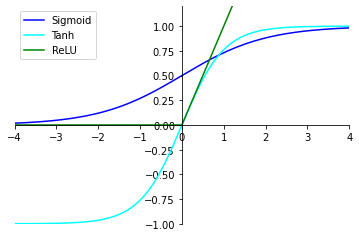

In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt

# set x's range
x = np.arange(-10, 10, 0.1)
y1 = 1 / (1 + math.e ** (-x))  # sigmoid
y2 = (math.e ** (x) - math.e ** (-x)) / (math.e ** (x) + math.e ** (-x))  # tanh
y3 = np.where(x < 0, 0, x)  # relu
plt.xlim(-4, 4)
plt.ylim(-1, 1.2)
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))

# Draw pic
plt.plot(x, y1, label='Sigmoid', linestyle="-", color="blue")
plt.plot(x, y2, label='Tanh', linestyle="-", color="cyan")
plt.plot(x, y3, label='ReLU', linestyle="-", color="green")
# Title
plt.legend(['Sigmoid', 'Tanh', 'Relu'])
plt.legend(loc='upper left')  # 将图例放在左上角

# show it!!
plt.show()

In [15]:
import torch
from torch import nn
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

dataset = torchvision.datasets.CIFAR10(
    "./datasets/",
    train = False,
    transform = torchvision.transforms.ToTensor(),
    download = True
)
dataloader = DataLoader(dataset, batch_size=64)

input = torch.tensor([
    [1, -0.5],
    [-1, 3]
])
input = torch.reshape(input, (-1, 1, 2, 2))
class ReLUNN(nn.Module):
    def __init__(self):
        super(ReLUNN, self).__init__()
        self.relu1 = ReLU()
        
    def forward(self, input):
        output = self.relu1(input)
        return output
    
class SigmodNN(nn.Module):
    def __init__(self):
        super(SigmodNN, self).__init__()
        self.relu1 = Sigmoid()
        
    def forward(self, input):
        output = self.relu1(input)
        return output
    
test = SigmodNN()
# output = test(input)
step = 0
writer = SummaryWriter("logs")
for data in dataloader:
    images, targets = data
    output = test(images)
    writer.add_images("input_sigmoid", images, step)
    writer.add_images("output_sigmoid", output, step)
    step = step + 1
    
writer.close()

Files already downloaded and verified


#### LINEAR
`torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)`

Applies a linear transformation to the incoming data: $y = xA^T + b$
##### Parameters
* `in_features` - size of each input simple
* `out_features` - size of each output sample
* `bias` - If set to `False`, the layer will not learn an additive bias. Default: `True`

##### Variables
* `weight` - the learnable weights of the module of shape $(out\_features, in\_features)$. The values are initialized from $u(-\sqrt{k}, \sqrt{k})$, where $k = \frac{1}{in\_features}$
* `bias` - the learnable bias of the module of shape $(out\_features)$. If `bias` is `True`, the values are initialized from $u(-\sqrt{k}, \sqrt{k})$, where $k = \frac{1}{in\_features}$

In [3]:
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader

dataset = torchvision.datasets.CIFAR10("./datasets/", train=False, transform=torchvision.transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=64)
class LinearTest(nn.Module):
    def __init__(self):
        super(LinearTest, self).__init__()
        self.linear1 = nn.Linear(196608, 10)
        
    def foward(self, input):
        output = self.linear1(input)
        
for data in dataloader:
    images, targets = data
    output = torch.flatten(images)

Files already downloaded and verified


### SEQUENTIAL
![](https://www.researchgate.net/profile/Yiren-Zhou-6/publication/312170477/figure/fig2/AS:448817725218817@1484017892180/Structure-of-CIFAR10-quick-model.png)

In [15]:
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, Sequential
from torch.utils.tensorboard import SummaryWriter

class SequentialTest(nn.Module):
    def __init__(self):
        super(SequentialTest, self).__init__()
#         self.conv1 = Conv2d(32, 32, 5, padding=2)
#         self.maxPool1 = MaxPool2d(2)
#         self.conv2 = Conv2d(32, 32, 5, padding=2)
#         self.maxPool2 = MaxPool2d(2)
#         self.conv3 = Conv2d(32, 64, 5, padding=2)
#         self.maxPool3 = MaxPool2d(2)
#         self.flatten = Flatten()
#         self.linear1 = Linear(1024, 64)
#         self.linear2 = Linear(64, 10)
        
        self.model = Sequential(
            Conv2d(3, 32, 5, padding=2),
            MaxPool2d(2),
            Conv2d(32, 32, 5, padding=2),
            MaxPool2d(2),
            Conv2d(32, 64, 5, padding=2),
            MaxPool2d(2),
            Flatten(),
            Linear(1024, 64),
            Linear(64, 10)
        )
        
    def forward(self, x):
#         x = self.conv1(x)
#         x = self.maxPool1(x)
#         x = self.conv2(x)
#         x = self.maxPool2(x)
#         x = self.conv3(x)
#         x = self.maxPool3(x)
#         x = self.flatten()
#         x = self.linear1(x)
#         x = self.linear2(x)
        x = self.model(x)
        return x
        
test = SequentialTest()
input = torch.ones((64, 3, 32, 32))
output = test(input)
print(output.shape)
writer = SummaryWriter("logs")
writer.add_graph(test, input)
writer.close()

torch.Size([64, 10])


### Loss Function
#### L1Loss
Creates a criterion that measures the **mean absolute error (MAE)** between each element in the input $x$ and target $y$. The unreduced (i.e. with `reduction` set to `none`) loss can be described as:
$$\mathscr{l}(x, y) = L = \{l_i, \cdots , l_N\}^T, l_n = |x_n - y_n|$$
Where $N$ is the batch size. If `reduction` is not `none` (default `mean`), then:
$$
\mathscr{l}(x, y) = 
\begin{cases}
mean(L), \ if \ reduction = `mean` \\
sum(L), \ if \ rduction = `sum`
\end{cases}
$$
$x$ and $y$ are tensors of arbitrary (任意的) shapes with a total of $n$ elements each. 

The sum operation still operates over all the elements, and divides by $n$. The division by $n$ can be avoided if one sets `reduction` = `sum`.

##### Parameters
* `size_average` - Deprecated. By default, the losses are averaged over each loss element in the batch. Note that for some losses, there are multiple elements per sample. If the field `size_average` is set to `False`, the losses are instead summed for each minibatch. Ignored when `reduce` is `False`. Default: `True`
* `reduce` - Deprecated.
* `reduction` - Specifies the reduction to apply to the output: `none` | `mean` | `sum`.
    * `none`: no reduction will be applied
    * `mean`: the sum of the output will be divided by the number of elements in the output
    * `sum`: the output will be summed
    
#### MSELoss
Creates a criterion that measures the **mean squared error (squared L2 norm)** between each element in the input $x$ and target $y$. The unreduced (i.e. with `reduction` set to `none`) loss can be described as:
$$\mathscr{l}(x, y) = L = \{l_i, \cdots , l_N\}^T, l_n = (x_n - y_n)^2$$
Where $N$ is the batch size. If `reduction` is not `none` (default `mean`), then:
$$
\mathscr{l}(x, y) = 
\begin{cases}
mean(L), \ if \ reduction = `mean` \\
sum(L), \ if \ rduction = `sum`
\end{cases}
$$
$x$ and $y$ are tensors of arbitrary (任意的) shapes with a total of $n$ elements each. 

#### CrossEntropyLoss
This criterion computes the cross entropy loss between input logits and target. It is useful when training a classification problem with $C$ classes. If provided, the optional argument `weight` should be be a 1D Tensor assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set.

The `input` is expected to contain the unnormalized logits for each class (which do not need to be positive or sum to 1, in general). `input` has to be a Tensor of size($C$) for unbatched input, (minibatch, $C$) or (minibatch, $C, d_1, d_2, \cdots, d_K$) with $K \geq 1$ for the K-dimensional case. The last being useful for higher dimension inputs, such as computing cross entropy loss per-pixel for 2D images.

The target that this criterion expects should contain either:
* Class indices in the range $[0, C)$ where $C$ is number of classes; if `ignore_index` is specified, this loss also accepts this class index (this index may not necessarily in the class range). The unreduced (i.e. with set to) loss for this case can be described as : `reduction` `none`
$$
\mathscr{l}(x, y) = L = \{l_1, \cdots, l_N\}^T, l_n = -\mathscr{w}_{y_n}log\frac{exp(x_{n, y_n})}{\sum_{c=1}^{C}exp(x_n, c)} \cdot 1 \{y_n \neq ignore\_index\}
$$
where $x$ is the input, $y$ is the target, $\mathscr{w}$ is the weight, $C$ is the number of classes, and $N$ spans the minibatch dimension as well as $d_1, \cdots, d_k$ for K-dimensional case. If is not (default), then `reduction` `none` `mean`
$$
\mathscr{l}(x, y) = 
\begin{cases}
\sum_{n = 1}^N{\frac{1}{\sum_{n = 1}^N{\mathscr{w} \cdot 1 \{y_n \neq ignore\_index\}}}}l_n & if \ reduction = `mean`;\\
\sum_{n = 1}^N{l_n} & if \ reduction = `sum`.
\end{cases}
$$
Note that this case is equivalent to applying `LogSoftmax` on an input, followed by `NLLLoss`.
* Probabilities for each class; useful when labels beyond a single class per minibatch item are required, such as for blended labels, label smoothing, etc. The unreduced (i.e. with set to) loss for this case can be described as: `reduction` `none`
$$
\mathscr{l}(x, y) = L = \{l_1, \cdots, l_N\}^T, l_n = -\sum_{c = 1}^C \mathscr{w}_{c}log\frac{exp(x_{n, c})}{\sum_{c=1}^{C}exp(x_{n, i})} y_{n, c}
$$
where $x$ is the input, $y$ is the target, $\mathscr{w}$ is the weight, $C$ is the number of classes, and $N$ spans the minibatch dimension as well as $d_1, \cdots, d_k$ for the K-dimensional case. If is not (default), then `reduction` `none` `mean`
$$
\mathscr{l}(x, y) = 
\begin{cases}
\frac{\sum_{n = 1}^N l_n}{N}, & if \ reduction = `mean`; \\
\sum_{n = 1}^N{l_n}, & if \ reduction = `sum`.
\end{cases}
$$

##### Parameters
* `weight` - a manual rescaling weight given to each class. If given, has to be a Tensor of size $C$ and floating point dtype
* `ignore_index` - Specifies a target value that is ignored and does not contribute to the input gradient. When is ,the loss is averaged over non-ignored targets. Note that is only applicable when the target contains class indices. `size_average` `True` `ignore_index`
* `reduction` - Specifies the reduction to apply to the output:
    * `none`: no reduction will be applied
    * `mean`: the weighted mean of the output is taken
    * `sum`: the output will be summed
* `label_smoothing` - A float in $[0.0, 1.0]$. Specifies the amount of smoothing when computing the loss, where $0.0$ mans no smoothing. The targets become a mixture of the original ground truth and a uniform distribution as described in [Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/abs/1512.00567). Default: $0.0$

##### Shape
* Input: Shape$(C)$, $(N, C)$ or $(N, C, d_1, d_2, \cdots, d_K)$ with $K \geq 1$ in the case of K-dimensional loss.
* Target: If containing class indices, shape$()$, $N$ or $(N, d_1, d_2, \cdots, d_K)$ with $K \geq 1$ in the case of K-dimensional loss where each value should be between $[0, C)$, If containing class probabilities, same shape as the input and each value should be between $[0, 1]$.
* Output: If reduction is `none`, shape $()$, $(N)$ or $(N, d_1, d_2, \cdots, d_K)$ with $K \geq 1$ in the case of K-dimensional loss, depending on the shape of the input. Otherwise, scalar.

where:
$$
\begin{align}
C &= number \ of \ classes \\
N &= batch \ size
\end{align}
$$

In [9]:
import torch
from torch import nn

# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input,target)
output.backward()
print(input, target, output)

# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output.backward()
print(input, target, output)

tensor([[ 0.0977,  0.4765, -0.8041,  0.0542, -0.2359],
        [-0.3361, -1.1238,  1.0310,  0.3329, -1.1886],
        [ 2.9726, -0.1864,  0.6002,  1.4690,  0.3177]], requires_grad=True) tensor([4, 2, 1]) tensor(2.0146, grad_fn=<NllLossBackward0>)
tensor([[-0.7895, -0.6270, -1.3918,  0.0207, -0.1117],
        [-0.0178,  0.1340, -1.0316,  0.0742, -0.9761],
        [-0.0408, -0.4790,  0.9696,  0.5091, -0.0875]], requires_grad=True) tensor([[0.3869, 0.1456, 0.1144, 0.2700, 0.0830],
        [0.0730, 0.1722, 0.3235, 0.3899, 0.0413],
        [0.1855, 0.6401, 0.0980, 0.0262, 0.0502]]) tensor(1.8426, grad_fn=<DivBackward1>)


> `loss.backward()`：根据当前的损失值（通常是一个标量）计算模型参数的梯度。它会从损失开始，然后通过模型的各个层反向传播梯度，最终计算出每个参数相对于损失的梯度。这些梯度将被用于后续的参数更新，以减小损失；将损失$\mathscr{l}$向输入侧进行反向传播，同于对于需要进行梯度计算的所有变量$x$ `(require_grad=True)`，计算梯度$\frac{\mathrm{d}}{\mathrm{d}x}\mathscr{l}$，并将其累积到梯度$x.grad$中备用，即：$x.grad = x.grad + \frac{\mathrm{d}}{\mathrm{d}x}\mathscr{l}$

In [7]:
import torch
from torch.nn import L1Loss
from torch.nn import MSELoss
from torch.nn import CrossEntropyLoss

inputs = torch.tensor([1, 2, 3], dtype=torch.float32)
targets = torch.tensor([1, 2, 5], dtype=torch.float32)

inputs = torch.reshape(inputs, (1, 1, 1, 3))
targets = torch.reshape(targets, (1, 1, 1, 3))

loss = L1Loss(reduction='sum')
res = loss(inputs, targets)
print(res)
lose_mse = MSELoss()
res = lose_mse(inputs, targets)
print(res)

x = torch.tensor([0.1, 0.2, 0.3])
x = torch.reshape(x, (1, 3))
y = torch.tensor([1])
loss = CrossEntropyLoss()
res = loss(x, y)
print(res)

tensor(2.)
tensor(1.3333)
tensor(1.1019)


In [16]:
import torchvision
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, Sequential
from torch.utils.data import DataLoader

class CrossEntropyLossTest(nn.Module):
    def __init__(self):
        super(CrossEntropyLossTest, self).__init__()
        
        self.model = Sequential(
            Conv2d(3, 32, 5, padding=2),
            MaxPool2d(2),
            Conv2d(32, 32, 5, padding=2),
            MaxPool2d(2),
            Conv2d(32, 64, 5, padding=2),
            MaxPool2d(2),
            Flatten(),
            Linear(1024, 64),
            Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x
        
dataset = torchvision.datasets.CIFAR10("./datasets/", train=False, transform=torchvision.transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=64)
test = CrossEntropyLossTest()
loss = CrossEntropyLoss()
for data in dataloader:
    images, targets = data
    outputs = test(images)
    res = loss(outputs, targets)
    res.backward()

Files already downloaded and verified


### Optimizer
#### How to use an optimizer
##### Constructing it
To Construct an Optimizer you have to give it  an iterable containing the parameters (all should be `Variable`) to optimize. Then, you can specify optimizer-specific (细节；特性) options such as the learning rate, weight decay (权重衰减), etc.

##### Per-parameter options
Optimizers also support specifying per-parameter options. To do this, instead of passing a iterable of `Variable`, pass in an iterable of dict. Each of them will define a separate parameter group, and should contain a `param` key, containing a list of parameters belonging to it. Other keys should match the keyword arguments accepted by the optimizers, and will be used as optimization options for this group.

For example, this is very useful when one wants to specify per-layer learning rates:
```python
optim.SGD([
    {'params': model.base.parameters()},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
], lr=1e-2, momentum=0.9)
```

##### Taking an optimization step
All optimizers implement a `step()` method, that updates the parameters. It cane be used in two ways:
* `optimizer.step()` - This is a simplified version support by most optimizers. The function can be called once the gradients are computed using e.g. `backward()`. 梯度被计算出来之后即可调用
* `optimizer.step(closure)` - Some optimization algorithm such as Conjugate Gradient (共轭梯度法) and LBFGS (拟牛顿法) need to reevalute the function multiple times, so you have to pass in a closure that allows them to recompute your model. The closure clear the gradients, compute the loss, and return it.
```python
for input, target in dataset:
    def closure():
        optimizer.zero_grad()
        output = loss_fn(output, target)
        loss.backward()
        return loss
    optimizer.step(closure)
```

#### Algorithms
##### Adadelta Algorithm

* * *

**input:** $\gamma$(lr), $\theta_0$(params), $f(\theta)$(objective), $\rho$(decay), $\lambda$(weight decay)
<br style="line-height:0.1;">
**initialize**: $v_0 \leftarrow 0$(square avg), $u_0 \leftarrow 0$(accumulate variables)
* * *
`for` $t = 1$ `to ... do`<br>
    $\quad g_t \leftarrow \nabla_\theta f_t(\theta_{t - 1})$<br>
    $\quad if \ \lambda \neq 0$<br>
        $\qquad g_t \leftarrow g_t + \lambda \theta_{t - 1}$<br>
    $\quad v_t \leftarrow v_{t - 1}\rho + g_t^2(1 - \rho)$<br>
    $\quad \Delta x_t \leftarrow \dfrac{\sqrt{u_{t - 1} + \epsilon}}{\sqrt{v_t + \epsilon}}g_t$<br>
    $\quad u_t \leftarrow u_{t - 1}\rho + \Delta x_t^2(1 - \rho)$<br>
    $\quad \theta_t \leftarrow \theta_{t - 1}\rho - \gamma\Delta x_t$<br>
* * *
`return` $\theta_t$
* * *
<br>

##### Adagrad Algorithm
* * *
**input:** $\gamma$(lr), $\theta_0$(params), $f(\theta)$(objective), $\rho$(decay), $\lambda$(weight decay), $\tau$(initial accumulator value), $\eta$(lr decay)
<br style="line-height:0.1;">
**initialize**: $state\_sum_0 \leftarrow 0$
* * *
`for` $t = 1$ `to ... do`<br>
    $\quad g_t \leftarrow \nabla_\theta f_t(\theta_{t - 1})$<br>
    $\quad \tilde{\gamma} \leftarrow \dfrac{\gamma}{1 + (t - 1) \eta} $<br>
    $\quad if \ \lambda \neq 0$<br>
        $\qquad g_t \leftarrow g_t + \lambda \theta_{t - 1}$<br>
    $\quad state\_sum_t \leftarrow state\_sum_{t - 1} + g_t^2$<br>
    $\quad \theta_t \leftarrow \theta_{t - 1}\rho - \tilde{\gamma}\dfrac{g_t}{\sqrt{state\_sum_t} + \epsilon}$<br>
* * *
`return` $\theta_t$
* * *

In [7]:
import torch
import torchvision
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, Sequential
from torch.utils.data import DataLoader

class OptimizerLossTest(nn.Module):
    def __init__(self):
        super(OptimizerLossTest, self).__init__()
        
        self.model = Sequential(
            Conv2d(3, 32, 5, padding=2),
            MaxPool2d(2),
            Conv2d(32, 32, 5, padding=2),
            MaxPool2d(2),
            Conv2d(32, 64, 5, padding=2),
            MaxPool2d(2),
            Flatten(),
            Linear(1024, 64),
            Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x
    
loss = nn.CrossEntropyLoss()
optimizerTest = OptimizerLossTest()
optimizer = torch.optim.SGD(optimizerTest.parameters(), lr=0.01)
dataset = torchvision.datasets.CIFAR10("./datasets/", train=False, transform=torchvision.transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=64)
for epoch in range(20):
    running_loss = 0.01
    for data in dataloader:
        images, targets = data
        outputs = optimizerTest(images)
        res_loss = loss(outputs, targets)
        optimizer.zero_grad()
        res_loss.backward()
        optimizer.step()
        running_loss = running_loss + res_loss
    print(running_loss)

Files already downloaded and verified
tensor(359.8171, grad_fn=<AddBackward0>)
tensor(349.5803, grad_fn=<AddBackward0>)
tensor(326.4633, grad_fn=<AddBackward0>)
tensor(315.0732, grad_fn=<AddBackward0>)
tensor(307.1474, grad_fn=<AddBackward0>)
tensor(297.9225, grad_fn=<AddBackward0>)
tensor(288.7407, grad_fn=<AddBackward0>)
tensor(281.0782, grad_fn=<AddBackward0>)
tensor(273.8957, grad_fn=<AddBackward0>)
tensor(267.2983, grad_fn=<AddBackward0>)
tensor(261.1341, grad_fn=<AddBackward0>)
tensor(255.4881, grad_fn=<AddBackward0>)
tensor(250.4390, grad_fn=<AddBackward0>)
tensor(245.8700, grad_fn=<AddBackward0>)
tensor(241.6462, grad_fn=<AddBackward0>)
tensor(237.7090, grad_fn=<AddBackward0>)
tensor(234.0188, grad_fn=<AddBackward0>)
tensor(230.5683, grad_fn=<AddBackward0>)
tensor(227.3083, grad_fn=<AddBackward0>)
tensor(224.1937, grad_fn=<AddBackward0>)


### torchvision.models
#### VGG

In [16]:
import torchvision
from torch import nn
# train_data = torchvision.datasets.ImageNet(
#     "./datasets_image_net/",
#     split="train",
#     download=True,
#     transform=torchvision.transforms.ToTensor()
# )
vgg16 = torchvision.models.vgg16(pretrained=True)
# train_data = torchvision.datasets.CIFAR10("./datasets/", train=True, transform=torchvision.transforms.ToTensor(), download=True)
vgg16.add_module("add_linear", nn.Linear(1000, 10))
vgg16.classifier.add_module("add_linear", nn.Linear(1000, 10))
vgg16.classifier[6] = nn.Linear(4096, 10)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### GPU Training

In [8]:
import torch
import time
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, Sequential
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torch.utils.data import DataLoader

class CifarModel(nn.Module):
    def __init__(self):
        super(CifarModel, self).__init__()
        
        self.model = Sequential(
            Conv2d(3, 32, 5, padding=2),
            MaxPool2d(2),
            Conv2d(32, 32, 5, padding=2),
            MaxPool2d(2),
            Conv2d(32, 64, 5, padding=2),
            MaxPool2d(2),
            Flatten(),
            Linear(1024, 64),
            Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

device = torch.device("cuda:0")
train_data = torchvision.datasets.CIFAR10("./datasets/", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_data = torchvision.datasets.CIFAR10("./datasets/", train=False, transform=torchvision.transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)
writer = SummaryWriter("logs/")
model = CifarModel()
model.to(device)
loss_func = nn.CrossEntropyLoss()
loss_func.to(device)
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

total_train_steps = 0
total_test_steps = 0
epoch = 10
for i in range(epoch):
    print("第{}轮训练开始".format(i + 1))
    start_time = time.time()
    model.train()
    for data in train_loader:
        images, targets = data
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = loss_func(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_steps = total_train_steps + 1
        if total_train_steps % 100 == 0:
            # print("训练次数：{}，loss：{}".format(total_train_steps, loss.item()))
            writer.add_scalar("train_loss", loss.item(), total_train_steps)
        
    model.eval()
    total_test_loss = 0
    total_test_accuracy = 0
    with torch.no_grad():
        for data in test_loader:
            images, targets = data
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = loss_func(outputs, targets)
            total_test_loss = total_test_loss + loss.item()
            accuracy = (outputs.argmax(1) == targets).sum()
            total_test_accuracy = total_test_accuracy + accuracy
    print("整体测试集上的loss：{}".format(total_test_loss))
    print("整体测试集上的正确率：{}".format(total_test_accuracy / len(test_data)))
    end_time = time.time()
    print("running time: {}".format(end_time - start_time))
    writer.add_scalar("test_loss", total_test_loss, total_test_steps)
    writer.add_scalar("test_accuracy", total_test_accuracy / len(test_data), total_test_steps)
    total_test_steps = total_test_steps + 1
    torch.save(model, "./models/test_{}".format(i))
    
writer.close()

Files already downloaded and verified
Files already downloaded and verified
第1轮训练开始
整体测试集上的loss：316.3902188539505
整体测试集上的正确率：0.27459999918937683
running time: 64.21319317817688
第2轮训练开始
整体测试集上的loss：303.25164806842804
整体测试集上的正确率：0.3166999816894531
running time: 64.35326194763184
第3轮训练开始
整体测试集上的loss：269.6542776823044
整体测试集上的正确率：0.3766999840736389
running time: 64.12790966033936
第4轮训练开始
整体测试集上的loss：265.72354912757874
整体测试集上的正确率：0.3953999876976013
running time: 64.27544069290161
第5轮训练开始
整体测试集上的loss：251.11966288089752
整体测试集上的正确率：0.4251999855041504
running time: 64.14677286148071
第6轮训练开始
整体测试集上的loss：236.13818204402924
整体测试集上的正确率：0.45909997820854187
running time: 63.203404903411865
第7轮训练开始
整体测试集上的loss：220.12329769134521
整体测试集上的正确率：0.4943999946117401
running time: 63.02765965461731
第8轮训练开始
整体测试集上的loss：206.44537925720215
整体测试集上的正确率：0.5300999879837036
running time: 63.66409635543823
第9轮训练开始
整体测试集上的loss：196.9747644662857
整体测试集上的正确率：0.5525999665260315
running time: 64.37123441696167
第10轮训练开始
整体测试集上

### Predict

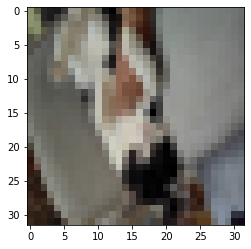

tensor([8], device='cuda:0')


In [16]:
import torch
import torchvision
from torch import nn
from torchvision.transforms import InterpolationMode
from PIL import Image
import matplotlib.pyplot as plt

class CifarModel(nn.Module):
    def __init__(self):
        super(CifarModel, self).__init__()
        
        self.model = Sequential(
            Conv2d(3, 32, 5, padding=2),
            MaxPool2d(2),
            Conv2d(32, 32, 5, padding=2),
            MaxPool2d(2),
            Conv2d(32, 64, 5, padding=2),
            MaxPool2d(2),
            Flatten(),
            Linear(1024, 64),
            Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

image = Image.open("IMG_20231124_082111.jpg")
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32), interpolation=InterpolationMode.BICUBIC),
    torchvision.transforms.ToTensor()
])
image = transform(image)
plt.imshow(image.transpose(0, 2).numpy())
plt.show()
image = torch.reshape(image, (1, 3, 32, 32))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = image.to(device)
model = torch.load("./models/test_9")
model.eval()
with torch.no_grad():
    output = model(image)
print(output.argmax(1))